## import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [2]:
np.random.seed(123)
torch.manual_seed(123)

## define model architecture

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [4]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [5]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

## create data loaders

In [6]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

## define optimizer and run training epochs

In [7]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [8]:
for epoch in range(1, 2):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.333043
epoch: 1 [320/60000 (1%)]	 training loss: 1.943062
epoch: 1 [640/60000 (1%)]	 training loss: 1.304336
epoch: 1 [960/60000 (2%)]	 training loss: 1.238040
epoch: 1 [1280/60000 (2%)]	 training loss: 0.958737
epoch: 1 [1600/60000 (3%)]	 training loss: 0.493184
epoch: 1 [1920/60000 (3%)]	 training loss: 0.643627
epoch: 1 [2240/60000 (4%)]	 training loss: 0.265545
epoch: 1 [2560/60000 (4%)]	 training loss: 0.560548
epoch: 1 [2880/60000 (5%)]	 training loss: 0.261553
epoch: 1 [3200/60000 (5%)]	 training loss: 0.306239
epoch: 1 [3520/60000 (6%)]	 training loss: 0.300254
epoch: 1 [3840/60000 (6%)]	 training loss: 0.261871
epoch: 1 [4160/60000 (7%)]	 training loss: 0.253512
epoch: 1 [4480/60000 (7%)]	 training loss: 0.103370
epoch: 1 [4800/60000 (8%)]	 training loss: 0.244615
epoch: 1 [5120/60000 (9%)]	 training loss: 0.246581
epoch: 1 [5440/60000 (9%)]	 training loss: 0.426752
epoch: 1 [5760/60000 (10%)]	 training loss: 0.164684
epoch: 1 [6080/60

epoch: 1 [48960/60000 (82%)]	 training loss: 0.189037
epoch: 1 [49280/60000 (82%)]	 training loss: 0.027550
epoch: 1 [49600/60000 (83%)]	 training loss: 0.030760
epoch: 1 [49920/60000 (83%)]	 training loss: 0.047113
epoch: 1 [50240/60000 (84%)]	 training loss: 0.201450
epoch: 1 [50560/60000 (84%)]	 training loss: 0.163309
epoch: 1 [50880/60000 (85%)]	 training loss: 0.230963
epoch: 1 [51200/60000 (85%)]	 training loss: 0.208547
epoch: 1 [51520/60000 (86%)]	 training loss: 0.193209
epoch: 1 [51840/60000 (86%)]	 training loss: 0.052333
epoch: 1 [52160/60000 (87%)]	 training loss: 0.071918
epoch: 1 [52480/60000 (87%)]	 training loss: 0.104872
epoch: 1 [52800/60000 (88%)]	 training loss: 0.100245
epoch: 1 [53120/60000 (89%)]	 training loss: 0.116145
epoch: 1 [53440/60000 (89%)]	 training loss: 0.052742
epoch: 1 [53760/60000 (90%)]	 training loss: 0.207156
epoch: 1 [54080/60000 (90%)]	 training loss: 0.055222
epoch: 1 [54400/60000 (91%)]	 training loss: 0.100362
epoch: 1 [54720/60000 (91%)]

## run inference on trained model

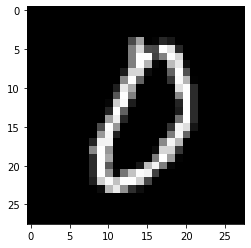

In [9]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [10]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 0
Ground truth is : 0


## captum tools

In [11]:
captum_input = sample_data[0].unsqueeze(0)
captum_input.requires_grad = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


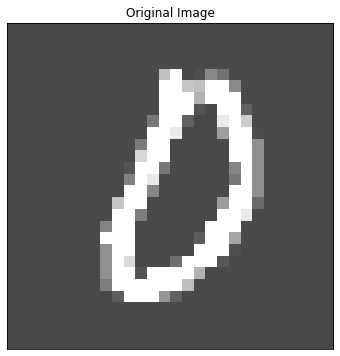

In [12]:
orig_image = np.tile(np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)), (1,1,3))
# tmp = np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
# orig_image = np.concatenate([tmp, np.zeros(tmp.shape), np.zeros(tmp.shape)], axis=2)
_ = viz.visualize_image_attr(None, orig_image, cmap='gray', method="original_image", title="Original Image")

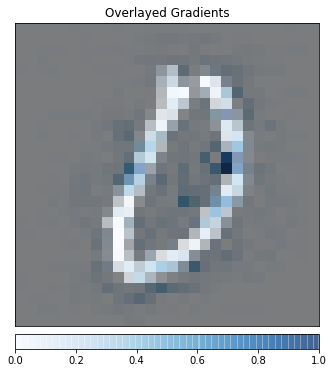

In [17]:
saliency = Saliency(model)
gradients = saliency.attribute(captum_input, target=sample_targets[0].item())
gradients = np.reshape(gradients.squeeze().cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(gradients, orig_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradients")

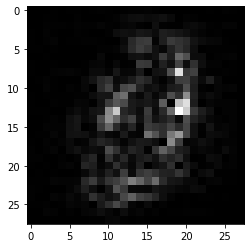

In [33]:
plt.imshow(np.tile(gradients/(np.max(gradients)), (1,1,3)));

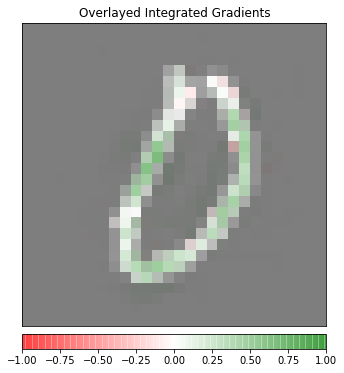

In [14]:
integ_grads = IntegratedGradients(model)
attributed_ig, delta = integ_grads.attribute(captum_input, target=sample_targets[0].item(), baselines=captum_input * 0, 
                              return_convergence_delta=True)
attributed_ig = np.reshape(attributed_ig.squeeze().cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(attributed_ig, orig_image, method="blended_heat_map",sign="all", show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

/Users/ashish.jha/opt/anaconda3/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


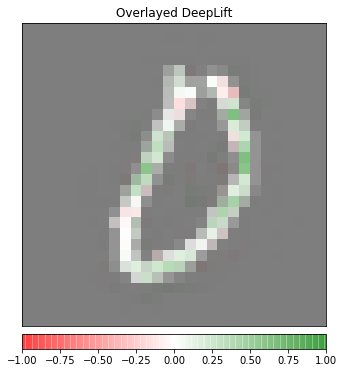

In [15]:
deep_lift = DeepLift(model)
attributed_dl = deep_lift.attribute(captum_input, target=sample_targets[0].item(), baselines=captum_input * 0, 
                              return_convergence_delta=False)
attributed_dl = np.reshape(attributed_dl.squeeze(0).cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(attributed_dl, orig_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")